In [1]:
from IPython.core.debugger import Tracer
import tensorflow as tf
import keras
import keras.losses
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping, Callback
import keras.backend as K

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import random
import csv
import os
import datetime
import socket
import socketserver
import warnings
from IPython.display import clear_output

np.set_printoptions(precision=10, suppress=True)
def my_mape(y_true, y_pred):
    return K.sum((K.abs(y_pred - y_true))/(K.abs(y_true)+0.0001))
keras.losses.my_mape = my_mape

Q_max = 1
Q_min = -1
def Q_normalize(Q_num):
    return (Q_num - Q_min)/(Q_max - Q_min)

def Q_denormalize(X_pred_nor):
    res = X_pred_nor.copy()
#     Freq = res[:,2:20]
#     res[:,2:20] = np.power(10, Freq)
    Q_num = res[:,1:]
    Q_num = Q_num*(Q_max - Q_min)+Q_min
    res[:,1:] = Q_num
    return res

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

Using TensorFlow backend.


In [ ]:
with open('./MATLAB/data/Generate/0610/temp_0.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(np.append(X_poles.reshape(-1, 1), X_Qnums, axis = 1))
with open('./MATLAB/data/Generate/0610/temp_error_0.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(np.append(X_eks.max(axis = 1).reshape(-1, 1), np.sqrt(np.mean(X_eks**2, axis = 1)).reshape(-1, 1), axis = 1))    


In [3]:
Y_in_ = []
Y_out_ = []
indices_ = []
data_idx = [0, 14]
# data_idx = range(15)
total = 0
for idx in data_idx:
    p_LQ = np.genfromtxt('./MATLAB/data/Generate/0610/temp_{}.csv'.format(idx), delimiter=',')[:,:1]
#     Freq = np.log10(np.genfromtxt('./MATLAB/data/Generate/0610/temp_0601_{}.csv'.format(idx), delimiter=',')[:,2:20])
    Q = Q_normalize(np.genfromtxt('./MATLAB/data/Generate/0610/temp_{}.csv'.format(idx), delimiter=',')[:,1:])
    Y_in_.append(np.hstack((p_LQ, Q)))
    Y_out_.append(np.genfromtxt('./MATLAB/data/Generate/0610/temp_error_{}.csv'.format(idx), delimiter=',')[:,0]*1000)
    print(Y_in_[-1].shape, Y_out_[-1].shape)
    indices_.append(np.arange(Y_in_[-1].shape[0]) + total)
    total += Y_in_[-1].shape[0]
    np.random.shuffle(indices_[-1])


(300, 16) (300,)
(300, 16) (300,)


(300, 1) (300, 15) (600, 16) (600,)


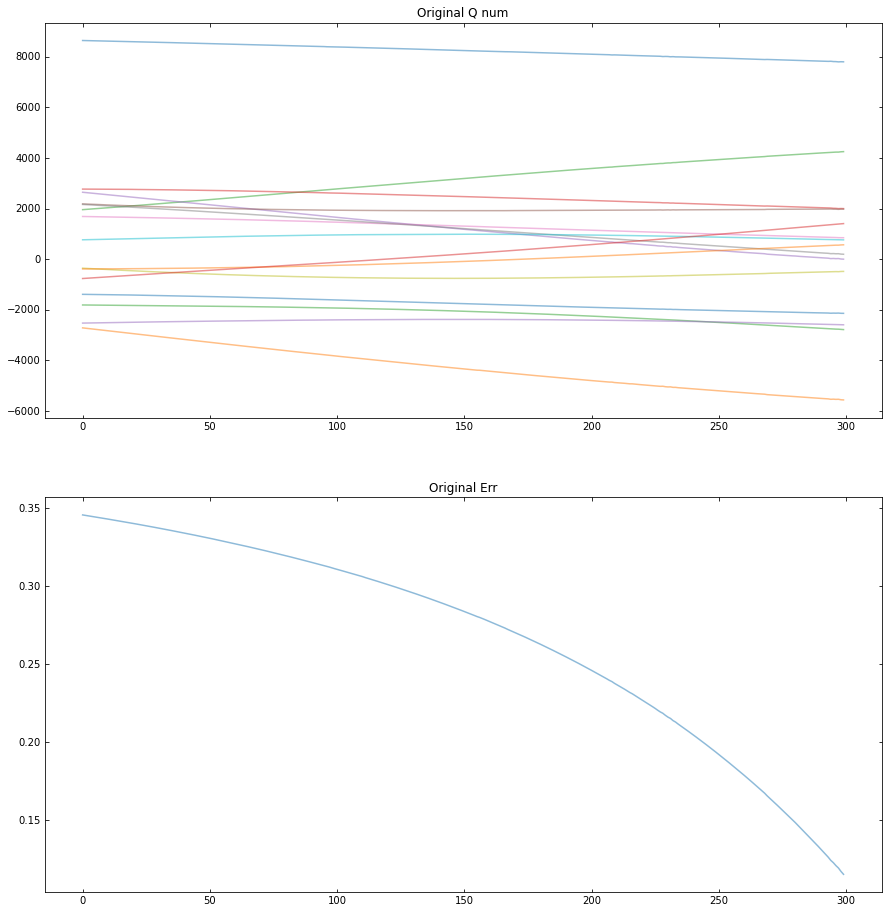

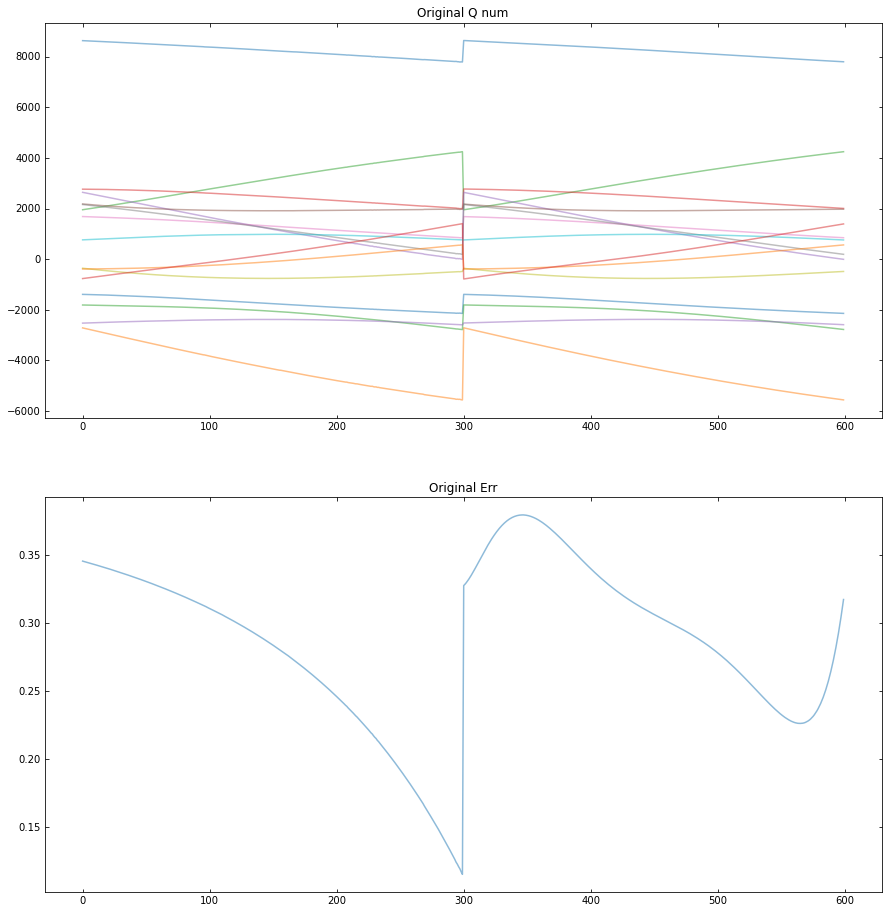

In [4]:
X_in = Y_in_[0][:,0:1]
X_out = Y_in_[0][:,1:]
Y_in = Y_in_[0]
Y_out = Y_out_[0]
for i in range(1,len(Y_out_)):
    Y_in = np.append(Y_in, Y_in_[i], axis = 0)
    Y_out = np.append(Y_out, Y_out_[i], axis = 0)
Y_in = np.delete(Y_in, np.where(Y_out != Y_out), axis = 0)
Y_out = np.delete(Y_out, np.where(Y_out != Y_out), axis = 0)
print(X_in.shape, X_out.shape, Y_in.shape, Y_out.shape)
indices = np.arange(Y_in.shape[0])
np.random.shuffle(indices)

fig = plt.figure(figsize=(15, 16))
ax1 = host_subplot(211, axes_class=AA.Axes)
for i in range(15):
    ax1.plot(Q_denormalize(Y_in_[0])[:,i+1], alpha = 0.5)
    ax1.set_title('Original Q num')
    

ax1 = host_subplot(212, axes_class=AA.Axes)
ax1.plot(Y_out_[0], alpha = 0.5)
ax1.set_title('Original Err')
# ax1.set_ylim(0,10)
plt.show()


fig = plt.figure(figsize=(15, 16))
ax1 = host_subplot(211, axes_class=AA.Axes)
for i in range(15):
    ax1.plot(Q_denormalize(Y_in)[:,i+1], alpha = 0.5)
    ax1.set_title('Original Q num')

ax1 = host_subplot(212, axes_class=AA.Axes)
ax1.plot(Y_out, alpha = 0.5)
ax1.set_title('Original Err')
# ax1.set_ylim(0,50)
plt.show()


In [ ]:
keras.backend.clear_session()

In [5]:
def __discriminator():
    """ Declare discriminator """
    model = Sequential()
    model.add(Dense(units=32, input_dim=Y_in.shape[1], kernel_initializer='normal'))
#     model.add(Dropout(0.1))
#     model.add(BatchNormalization())
#     model.add(Dense(units=64, kernel_initializer='normal', activation='sigmoid'))
#     model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(units=16, activation='sigmoid'))
#     model.add(Dropout(0.1))
    model.add(Dense(units=1))
    model.name = "D"
    return model

In [6]:
def __generator():
    """ Declare generator """
    G_in = Input(shape = (X_in.shape[1],))
    L1 = Dense(units=32, kernel_initializer='normal')(G_in)
#     L1 = Dropout(0.1)(L1)
#     L1 = Dense(units = 64)(L1)
#     L1 = Dropout(0.1)(L1)
#     L1 = BatchNormalization()(L1)
#     L1 = Dense(units = 64, activation='sigmoid')(L1)
    L1 = Dropout(0.1)(L1)
#     L1 = BatchNormalization()(L1)
    L1 = Dense(units = 32, activation='sigmoid')(L1)
    G_out = Dense(units = X_out.shape[1])(L1)
    G_out = Concatenate(axis = -1)([G_in, G_out])
    model = Model(inputs = G_in, outputs = G_out)
    model.name = "G"
    return model

In [7]:
def __stacked_generator_discriminator(self_G, self_D):
    self_D.trainable = False
    model = Sequential()
    model.add(self_G)
    model.add(self_D)
    model.name = "GD"
    return model

In [ ]:
self_D = __discriminator()
self_D.summary()

In [ ]:
self_G = __generator()
self_G.summary()

In [ ]:
self_stacked_GD = __stacked_generator_discriminator(self_G, self_D)
self_stacked_GD.summary()

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
self_D.trainable = True
self_D.compile(loss = 'mape', optimizer = Nadam(lr=0.002))
train_history_D = self_D.fit(x=Y_in, y=Y_out, 
                             validation_split=0, epochs=100000, batch_size=128, verbose=1, 
                             callbacks = [tensorboard_callback, 
                                          EarlyStopping(monitor = 'loss', patience = 5000, verbose = 1, mode = 'auto'),
                                          EarlyStoppingByLossVal(monitor='loss', value=0.05, verbose=1)])

In [ ]:
self_G.compile(loss='mae', optimizer=Nadam(lr=0.002))
train_history_G = self_G.fit(x=X_in, y=Y_in[:X_in.shape[0]],
                               validation_split=0, epochs=1000000, batch_size=128, verbose=1, 
                               callbacks = [tensorboard_callback, EarlyStopping(monitor = 'loss', patience = 1000, verbose = 1, mode = 'auto')])

In [ ]:
mislabled = np.zeros((Y_in_[0].shape[0], 1))
self_D.trainable = False
self_stacked_GD.compile(loss='mape', optimizer=Nadam(lr=0.0001))
train_history_GD = self_stacked_GD.fit(x=X_in[indices_[0]], y=Y_out[indices_[0]], 
# train_history_GD = self_stacked_GD.fit(x=X_in, y=mislabled,
                                       validation_split=0.1, epochs=1000000, batch_size=64, verbose=1, 
                                       callbacks = [tensorboard_callback, EarlyStopping(monitor = 'loss', patience = 1000, verbose = 1, mode = 'auto')])

In [ ]:
self_G.save('./models/Simulator_DesignF2Qnum_0611_1.h5')
self_D.save('./models/Simulator_Qnum2Errmax_0611_1.h5')
self_stacked_GD.save('./models/Stacked_GAN_0611_1.h5')

In [ ]:
serverSocket =socket.socket(socket.AF_INET,socket.SOCK_STREAM)
serverSocket.bind (('127.0.0.1',50000))
serverSocket.listen(1)

In [ ]:
train_history_D = []
train_history_GD = []
for idx in range(20):

    X_pred = self_G.predict(X_in)
    with open('./MATLAB/data/Generate/temp.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(Q_denormalize(X_pred))
    print("start matlab")
    os.system(r"matlab -r \"run('C:\Users\dalek669528\Desktop\CNC_proj\MATLAB\Simulation_FixedQ_Ccode\X_main_fixedQ_Ccode_func.m')\"")
    print("open socket")
    connectionSocket, addr = serverSocket.accept()
    
#     connectionSocket, addr = serverSocket.accept()
    sentence = connectionSocket.recv(1024)
    print(sentence.decode())
    connectionSocket.close() 
    with open('./MATLAB/data/Generate/0610/temp_{}.csv'.format(len(Y_out_)), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(np.genfromtxt('./MATLAB/data/Generate/temp.csv', delimiter=','))
    with open('./MATLAB/data/Generate/0610/temp_error_{}.csv'.format(len(Y_out_)), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(np.genfromtxt('./MATLAB/data/Generate/temp_error.csv', delimiter=','))    
    p_LQ = np.genfromtxt('./MATLAB/data/Generate/temp.csv', delimiter=',')[:,:1]
    #     Freq = np.log10(np.genfromtxt('./MATLAB/data/Generate/temp.csv', delimiter=',')[:,2:20])
    Q = Q_normalize(np.genfromtxt('./MATLAB/data/Generate/temp.csv', delimiter=',')[:,1:])
    Y_in_resimulate = np.hstack((p_LQ, Q))
    Y_out_resimulate = np.genfromtxt('./MATLAB/data/Generate/temp_error.csv', delimiter=',')[:,0]*1000
    Y_in_.append(Y_in_resimulate)
    Y_out_.append(Y_out_resimulate)
    Y_in = np.append(Y_in, Y_in_resimulate, axis=0)
    Y_out = np.append(Y_out, Y_out_resimulate)
    Y_in = np.delete(Y_in, np.where(Y_out != Y_out), axis = 0)
    Y_out = np.delete(Y_out, np.where(Y_out != Y_out), axis = 0)
    print(Y_in_[-1].shape, Y_out_[-1].shape, len(Y_in))
    indices = np.arange(Y_in.shape[0])
    np.random.shuffle(indices)
    
    
#     with open('./MATLAB/data/Generate/check_{}.csv'.format(idx), 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(Q_denormalize(X_pred))
    self_G.save('./models/checkpoint/G_{}.h5'.format(idx))
    self_D.save('./models/checkpoint/D_{}.h5'.format(idx))
    self_stacked_GD.save('./models/checkpoint/StackGD_{}.h5'.format(idx))
    
    self_D.trainable = True
    self_D.compile(loss = 'mae', optimizer = Nadam(lr=0.001))
    train_history_D = self_D.fit(x=Y_in, y=Y_out, 
                                 validation_split=0, epochs=100000, batch_size=64, verbose=1, 
                                 callbacks = [tensorboard_callback, 
                                              EarlyStopping(monitor = 'loss', patience = 5000, verbose = 1, mode = 'auto'),
                                              EarlyStoppingByLossVal(monitor='loss', value=0.1, verbose=1)])

    mislabled = np.zeros((Y_in_[0].shape[0], 1))
#     self_G = __generator()
#     self_stacked_GD = __stacked_generator_discriminator(self_G, self_D)
    self_D.trainable = False
    self_stacked_GD.compile(loss='mae', optimizer=Nadam(lr=0.00001))
    train_history_GD = self_stacked_GD.fit(x=X_in[indices_[0]], y=Y_out[indices_[0]], 
    # train_history_GD = self_stacked_GD.fit(x=X_in[:3750], y=mislabled,
                                           validation_split=0.1, epochs=1000000, batch_size=64, verbose=1, 
                                           callbacks = [tensorboard_callback, 
                                                        EarlyStopping(monitor = 'loss', patience = 1000, verbose = 1, mode = 'auto'),
                                                        EarlyStoppingByLossVal(monitor='loss', value=0.05, verbose=1)])
    
    

In [ ]:
self_G = load_model('./models/Simulator_DesignF2Qnum_0601_4.h5') 
self_G.name = "G"
self_G.compile(loss=my_mape, optimizer=Adam(lr=0.0000001, beta_1=0.5, decay=8e-8))
self_G.summary()
self_D = load_model('./models/Simulator_Qnum2Errmax_0611_1.h5')
self_D.name = "D"
self_D.compile(loss='mape', optimizer=Adam(lr=0.000001, beta_1=0.5, decay=8e-8))
self_D.summary()

self_stacked_GD = __stacked_generator_discriminator(self_G, self_D)
self_stacked_GD.compile(loss='mae', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))
self_stacked_GD.summary()

In [ ]:
X_pred = self_G.predict(X_in)
Y_pred = self_stacked_GD.predict(X_in)
Y_pred_D = self_D.predict(Y_in)
fig = plt.figure(figsize=(15, 16))
ax1 = host_subplot(211, axes_class=AA.Axes)
for i in range(15):
    ax1.plot(Q_denormalize(Y_in_[0])[:,i+1], alpha = 0.5)
    ax1.set_title('Original Q num')
# plt.show()
# fig = plt.figure(figsize=(15, 8))
ax1 = host_subplot(212, axes_class=AA.Axes)
for i in range(15):
    ax1.plot(Q_denormalize(X_pred)[:,i+1], alpha = 0.8)
    ax1.set_title('Predict Q num')
plt.show()

fig = plt.figure(figsize=(15, 8))
ax1 = host_subplot(111, axes_class=AA.Axes)
ax1.plot(Y_out_[0], alpha = 1, label = "Original error")
ax1.plot(Y_pred, alpha = 0.5, label = "Predict error")
ax1.set_title('max error')
ax1.legend()
# ax1.set_ylim(0, 1)
plt.show()

fig = plt.figure(figsize=(15, 8))
ax1 = host_subplot(111, axes_class=AA.Axes)
ax1.plot(Y_out, alpha = 1, label = "Original error")
ax1.plot(Y_pred_D, alpha = 0.3, label = "Predict error")
ax1.set_title('max error')
ax1.legend()
ax1.set_ylim(0, 2)
plt.show()

# fig = plt.figure(figsize=(15, 8))
# ax1 = host_subplot(111, axes_class=AA.Axes)
# ax1.plot(Y_out, alpha = 0.5, label = "Original error")
# ax1.plot(Y_pred_D, alpha = 0.5, label = "Predict error")
# ax1.set_title('max error')
# ax1.legend()
# ax1.set_ylim(0, 50)
# plt.show()

In [ ]:
Y_pred_D = self_D.predict(Y_in)
fig = plt.figure(figsize=(15, 8))
ax1 = host_subplot(111, axes_class=AA.Axes)
ax1.plot(Y_out[:], alpha = 1, label = "Original error")
ax1.plot(Y_pred_D[:], alpha = 0.3, label = "Predict error")
ax1.set_title('max error')
ax1.legend()

In [ ]:
# Y_test = self_D.predict(Y_in)
fig = plt.figure(figsize=(15, 16))
ax1 = host_subplot(211, axes_class=AA.Axes)
ax1.plot(Y_out_, alpha = 0.9)
# ax1.plot(Y_test, alpha = 0.5)
# ax1 = host_subplot(212, axes_class=AA.Axes)
# ax1.plot(Y_out_3[:200], alpha = 0.9)
# ax1.plot(Y_test[:200], alpha = 0.5)
plt.show()

In [ ]:
for idx in range(len(Y_out_)):
    fig = plt.figure(figsize=(10, 8))
    ax1 = host_subplot(211, axes_class=AA.Axes)
    for i in range(15):
        ax1.plot(Q_denormalize(Y_in_[idx])[:,i+20], alpha = 0.5)
    ax1.set_title(idx)
#     ax1.set_xticklabels(['','3', '3.5', '4', '4.5', '5', '5.5', '6', '6.5'], fontsize = 30)
#     plt.show()

#     fig = plt.figure(figsize=(7, 5))
    ax1 = host_subplot(212, axes_class=AA.Axes)
    ax1.plot(Y_out_[idx], alpha = 0.5)
    # ax1.set_title('Original Err')
#     ax1.set_xticklabels(['','3', '3.5', '4', '4.5', '5', '5.5', '6', '6.5'], fontsize = 30)
    ax1.set_ylim(0,25)
    plt.show()